In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from scipy import stats
import pickle as pkl
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import cross_val_score
%matplotlib inline

In [ ]:
"""
Functions
"""

def calc_NMSE_error(X, y, model):
    '''returns in-sample error for already fit model.'''
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    nmse = -1*mse
    return nmse

In [41]:
with open("../data/iterate/luther_model_data_full.pkl", 'rb') as picklefile:
    sale = pkl.load(picklefile)
    
# potential zipcode filter to NW side
zips_nw = [60611, 60610, 60654, 60642,
           60622, 60647, 60614, 60657,
           60639, 60641, 60630, 60618,
           60613, 60640, 60625, 60660,
           60626, 60659, 60645]

#sale_nw = sale[sale['zipcode'].isin(zips_nw)]

sale.shape

(8000, 40)

In [75]:
"""
build/filter/transform target and features
"""

model_params = ['price','bedrooms','bathrooms','area','median_income','duration_float']#,'year_built','lot_size']#,'price_per_square_foot']

# filter down to correlation parameters
#sale = sale[sale['price']<1000000]
#sale = sale[sale['price_per_square_foot']<150]
#sale = sale[sale['lot_size']>10]
sale = sale.dropna(subset = model_params)
model = sale[model_params]
print(model.shape)
#filter out outliers
#model = model[(np.abs(stats.zscore(model)) < 3).all(axis=1)]

# decide if feature engineering is necessary
model['price']=model['price'].apply(np.log10)
model['area']=model['area'].apply(np.log10)

"""
set up train test split
"""
# make data for linear regression
y = model.pop('price').values
X = StandardScaler().fit_transform(model)

# first split out 20% of the data as a validation set
X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.2)

# now split out another 20% for cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3333333)

#build initial regression model

### cross validation testing
#setting up as a polynomial but using degree 1, just to have the easy option later
degree = 2
est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
lr = LinearRegression(fit_intercept=True)

scores_R = cross_val_score(est,
                         X_training,
                         y_training,
                         cv=10)#, scoring='neg_mean_squared_error')
scores_RMSE = cross_val_score(est,
                         X_training,
                         y_training,
                         cv=10, scoring='neg_mean_squared_error')



print(scores_R)
print(-scores_RMSE)



#print(est.named_steps['linearregression'].coef_[0:])
#print(est.named_steps['linearregression'].intercept_)

(1824, 6)
[0.41237569 0.34928404 0.49943342 0.40762444 0.21613186 0.52231517
 0.42289844 0.39793837 0.40386124 0.35865934]
[0.07093421 0.0598496  0.05770996 0.06838579 0.09417325 0.05451144
 0.07512331 0.07245337 0.06050126 0.07612086]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [73]:
est_fit = est.fit(X_training,y_training)
est.score(X_holdout,y_holdout)

0.3828580031983667

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


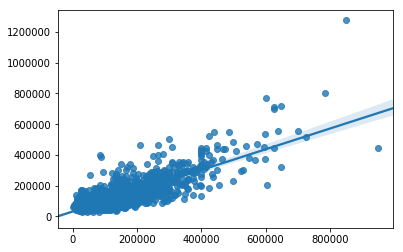

In [74]:
final = est.fit(X,y)
y_pred = final.predict(X)
ax = sns.regplot(10**y,10**y_pred)